Hello, I am JYC. This notebook implements all the sub-tasks in experimental topic 2. I will explain the logic behind each concept to assist students who are not proficient in coding to quickly grasp the key points and complete the experiment.

In [127]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Graph Generation

Here, I have defined three functions for generating networks: 
1. WS (Watt Strogtz) small world network `watts_strogatz_network`
2. NW (Newman Watt) small work network `newman_watts_network`
3. Scale-free network (Barabasi Albert model) `barabasi_albert_network`

In [128]:
def nearest_neighbor_network(num_nodes: int, k: int):
    assert k % 2 == 0, "K must be an even number"

    g = nx.Graph()
    nodes = list(range(num_nodes))
    for j in range(1, k // 2 + 1):
        g.add_edges_from(zip(nodes, nodes[j:] + nodes[0:j]))
    return g


def watts_strogatz_network(g: nx.Graph, p: float):

    assert 0 <= p <= 1, "Probability p must be between 0 and 1."

    small_world = g.copy()
    for u, u_nbrs in g.adj.items():
        for w in u_nbrs:
            if np.random.random() < p:
                possible_nodes = list(set(g.nodes) - set(g[u]) - {u})
                if len(possible_nodes) > 0:
                    if small_world.has_edge(u, w):
                        small_world.remove_edge(u, w)
                        v = np.random.choice(possible_nodes)
                        while small_world.has_edge(u, v):
                            v = np.random.choice(possible_nodes)
                        small_world.add_edge(u, v)

    return small_world


def newman_watts_network(g: nx.Graph, p: float):

    assert 0 <= p <= 1, "Probability p must be between 0 and 1."

    small_world = g.copy()
    for u in g.nodes:
        for v in g.nodes:
            if u != v and not g.has_edge(u, v):
                if np.random.random() < p:
                    small_world.add_edge(u, v)
    return small_world


def barabasi_albert_network(g: nx.Graph, n: int, m: int):
    g = g.copy()
    repeated_nodes = np.repeat(*np.array(list(g.degree())).T)
    source = len(g)
    while source < n: 
        targets = np.random.choice(repeated_nodes, m, replace=False)
        g.add_edges_from(zip([source] * m, targets))

        repeated_nodes = np.append(repeated_nodes, targets) 
        repeated_nodes = np.append(repeated_nodes, [source] * m)

        source += 1
    return g

## Metric Calculation

Additionally, we need to implement functions to calculate the average shortest path length and the clustering coefficient. Of course, we can also directly use `nx.single_source_shortest_path_length` and `nx.average_clustering` from the networkx library.

### Average Shortest Path Length
For calculating the average shortest path length, it is necessary to determine the all-pairs shortest paths. Since the graphs we generate are unweighted, we can simply use **Breadth-First Search** (BFS) on each node for `num_nodes` times. For simplicity, in this step, we will directly utilize `nx.single_source_shortest_path_length`. If the graph were weighted, for positive weights, we would use **Dijkstra**'s algorithm or the **Floyd-Warshall** algorithm, and for negative weights, we could use the **SPFA** algorithm or **Johnson**'s algorithm.

After we get shortest path length of each node, we can apply the following formula to get the result.
$$
L = \sum_{\substack{s,t \in V \\ s\neq t}} \frac{d(s, t)}{n(n-1)}
$$
 where `V` is the set of nodes in `g`, `d(s, t)` is the shortest path from `s` to `t`, and `n` is the number of nodes in `g`.


In [129]:
def average_shortest_path_length(g):
    n = len(g)
    return sum(
        l for s in g for l in nx.single_source_shortest_path_length(g, s).values()
    ) / (n * (n - 1))

### Clustering Coefficient
The clustering coefficient is a metric that describes the degree of local compactness around a vertex in a graph. To calculate the average clustering coefficient, we need to compute the clustering coefficient $C_u$, for each vertex and then take the average of these values.

The formula of clustering coefficient of one node `u` is as follows:
$$
      C_u = \frac{2 T(u)}{deg(u)(deg(u)-1)}
$$
where `T(u)` is the number of triangles through node `u` and `deg(u)` is the degree of `u`.

To calculate the clustering coefficient for a vertex  `u`  in a graph, we need to consider the number of triangles that  u  forms with its neighbors. Let's take vertex  `B`  as an example for  `u` , with neighbors  `u_nbrs = {A, C, D, E}` .

For each neighbor `v` of  `u` (for instance,  `v = C` ), we find  `v` 's neighbors (which are  `{A, B, E}`  in this example). We then take the intersection of  `u`'s neighbors and  `v`'s neighbors. The resulting nodes from this intersection are those that can form triangles with both `u` and `v`.
<div align="center">
<pre>
  A
 / \
  B---C
 / \ / \
D   E   F
</pre>
</div>


In [130]:
from collections import Counter


def average_clustering(g):
    def triangle_degree_iter():
        for u, u_nbrs in g.adj.items():
            u_nbrs = set(u_nbrs) - {u}  # remove self-loop if exists
            gen_degree = Counter(len(u_nbrs & (set(g[v]) - {v})) for v in u_nbrs)
            num_triangles = sum(k * val for k, val in gen_degree.items())
            yield (len(u_nbrs), num_triangles)

    return sum(
        0 if T == 0 else T / (deg * (deg - 1)) for deg, T in triangle_degree_iter()
    ) / len(g)

## Graph Visualization

Now that we've completed all the preparations, let's proceed to visualize each network. We'll use visual representation to better understand the structure and connectivity of each small world model. For this visualization, tools like NetworkX in combination with matplotlib or similar libraries can be employed to generate clear and informative graphs. These visualizations will help illustrate the differences and unique characteristics of each network configuration.

In [131]:
n = 10
k = 4 # for nearest neighbor coupled network
p = 0.1
m = 5 # for barabasi_albert_network

def show_graph(*graphs, **kwargs):
    cols = 2 if len(graphs) > 1 else 1
    rows = (len(graphs) + cols - 1) // cols 
    
    fig, axes = plt.subplots(rows, cols, figsize=(8, 4 * rows))
    if len(graphs) == 1:
        axes = [axes] 

    for i, g in enumerate(graphs):
        nx.draw(g, pos=nx.circular_layout(g), ax=axes[i], **kwargs)
        
        # verify the correctness of our implementation
        assert average_shortest_path_length(g) == nx.average_shortest_path_length(g)
        assert average_clustering(g) == nx.average_clustering(g)
        
        avg_path_len = nx.average_shortest_path_length(g)
        avg_clustering = nx.average_clustering(g)
        axes[i].set_title(f"Graph {i+1} - ASP: {avg_path_len:.2f}, ACC: {avg_clustering:.2f}")
    
    plt.tight_layout()
    plt.show()

### WS Small World Network

The WS (Watts-Strogatz) small-world model is derived from the nearest-neighbor coupled network. In this model, each edge of the network is rewired with a probability `p` by keeping one endpoint fixed and reconnecting the other endpoint to a randomly selected node in the network. This process introduces random shortcuts across the network, which significantly decreases the average path length while maintaining a high clustering coefficient, typical of small-world networks.

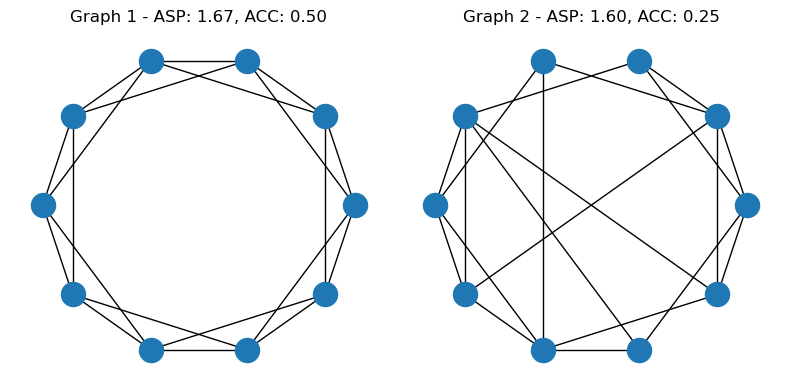

In [132]:
g = nearest_neighbor_network(n, k)
ws = watts_strogatz_network(g, p)
assert g.number_of_edges(), ws.number_of_edges()
show_graph(g, ws)

### NW Small World Network

Similarly, the NW (Newman-Watts) small-world model also originates from the nearest-neighbor coupled network. However, instead of rewiring the edges, it adds new edges with probability `p` between arbitrary pairs of nodes. This method of adding new links rather than replacing existing ones maintains the original local structure and potentially increases the number of shortcuts, enhancing the small-world effect without disrupting existing connections as much as the WS model might.

**NOTE**: In NetworkX, the construction method of the NWS small-world model differs from the my approach. For each edge `(u, v)`, the model adds a new edge `(u, w)` with a probability `p`, where `w` is a node randomly selected from the existing nodes.

I suspect this may be to maintain consistency with the implementation of the WS small-world model.

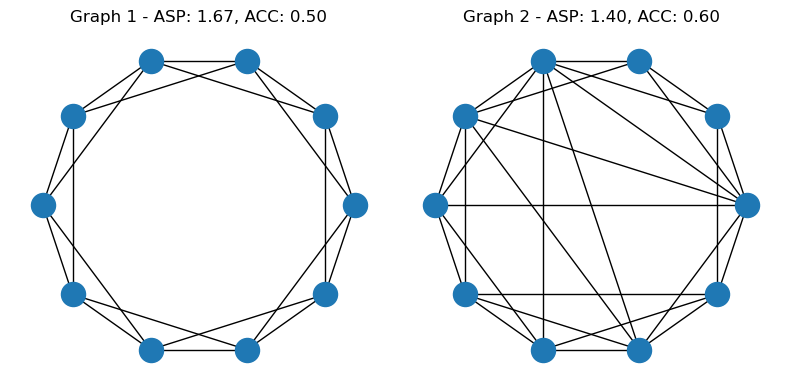

In [133]:
show_graph(g, newman_watts_network(g, p))

### Scale Free Network
Scale-free networks are network structures where the degree distribution of nodes follows a power-law distribution. This means that a small number of nodes have a high degree of connectivity, while the majority have relatively few connections. These networks are characterized by the absence of a typical scale or average, demonstrating large-scale heterogeneity in connectivity.

The Barabasi-Albert model is a type of scale-free network. It specifically explains how such networks evolve through the mechanism of preferential attachment, where new nodes are more likely to connect to existing nodes that already have a higher degree of connectivity. This model demonstrates the dynamic and organic growth of scale-free networks, contributing to the understanding of their widespread occurrence in natural and man-made systems.

To construct a Barabasi-Albert model with `n` nodes, you must first start with an initial graph containing `n0` nodes. The following steps are then repeated for `n - n0` iterations: a new node is added, and for each existing node `u`, it connects to  `m` other nodes with a probability:
$$
p = \frac{deg(u)}{\sum_{v \in V} deg(v)}
$$


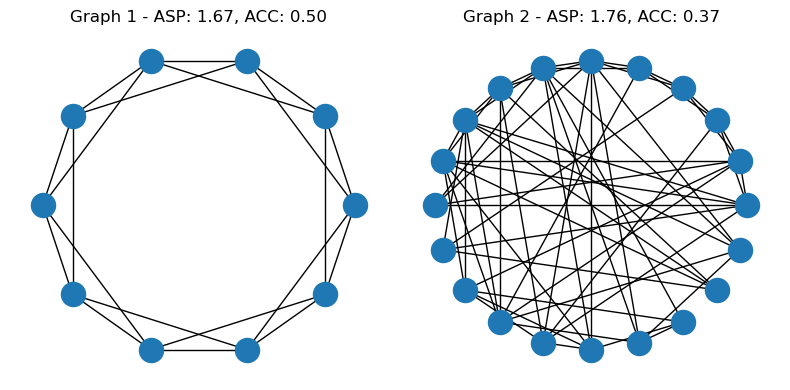

In [134]:
show_graph(g, barabasi_albert_network(g, n * 2, m))
